In [1]:
import os
import sys
import csv
import requests
import nbm_funcs

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

os.environ["OMP_NUM_THREADS"] = "1"

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [2]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KSEA'

# Data Range
lead_time_end = 263
init_hours = nbm_funcs._init_hours = [13]#[1, 7, 13, 19]

date0 = nbm_funcs._date0 = datetime(2020, 3, 1)#3, 1)
date1 = nbm_funcs._date1 = datetime(2020, 8, 15)#today

In [3]:
# datadir = nbm_funcs._datadir = '../archive/%s/data/'%site
datadir = nbm_funcs._datadir = '../archive/data/'
os.makedirs(datadir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, init_hours, date0, date1, date2))


Forecast Site: KSEA
Init Hours: [13]
First Init: 2020-03-01 00:00:00
Last Init: 2020-08-15 00:00:00
Last Verif: 2020-08-25 23:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [4]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KSEA
CWA: SEW
Zone: WA558


In [257]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
#     We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

meta.shape

(51, 19)

In [258]:
for k in meta:
    try:
        meta[k] = meta[k].astype(float)
    except:
        pass

<hr><hr>

## Plot a map of the stations, color by elevation, marker by network

In [259]:
import geopandas as gpd
from glob import glob

geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)
# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
zones = zones[zones['CWA'] == cwa]

# zones.to_file(geodir + 'forecast-zones.json', driver = 'GeoJSON')
zones

,TIME_ZONE,STATE,CWA,FE_AREA,ZONE,NAME,STATE_ZONE,LON,LAT,SHORTNAME,InPoly_FID,SimPgnFlag,MaxSimpTol,MinSimpTol,geometry
622,P,WA,SEW,nw,001,San Juan County,WA001,-122.9627,48.5786,San Juan County,3444,0,0.0001,0.0001,"MULTIPOLYGON (((-122.81197 48.41291, -122.8125..."
623,P,WA,SEW,nw,514,Eastern Strait of Juan de Fuca,WA514,-123.2615,48.0760,Eastern Strait of Juan de Fuca,3445,0,0.0001,0.0001,"MULTIPOLYGON (((-122.92453 48.06274, -122.9242..."
624,P,WA,SEW,nw,506,Western Skagit County,WA506,-122.3668,48.4646,Western Skagit County,3446,0,0.0001,0.0001,"MULTIPOLYGON (((-122.37564 48.29217, -122.3772..."
625,P,WA,SEW,wc,568,West Slopes North Central Cascades and Passes,WA568,-121.4861,47.8035,West Slopes North Central Cascd,3447,0,0.0001,0.0001,"POLYGON ((-121.58156 48.29923, -121.57692 48.2..."
626,P,WA,SEW,wc,555,East Puget Sound Lowlands,WA555,-122.0086,47.5465,East Puget Sound Lowlands,3448,0,0.0001,0.0001,"POLYGON ((-122.12630 48.29801, -122.11340 48.2..."
627,P,WA,SEW,wc,567,West Slopes North Cascades and Passes,WA567,-121.5187,48.6678,West Slopes North Cascades,3449,0,0.0001,0.0001,"POLYGON ((-121.94080 48.99981, -121.92020 48.9..."
628,P,WA,SEW,nw,513,Olympics,WA513,-123.5990,47.7525,Olympics,3450,0,0.0001,0.0001,"POLYGON ((-123.92160 48.11601, -123.86739 48.1..."
629,P,WA,SEW,wc,512,Lower Chehalis Valley Area,WA512,-123.5111,47.0579,Lower Chehalis Valley Area,3451,0,0.0001,0.0001,"POLYGON ((-123.77270 47.35121, -123.74870 47.3..."
630,P,WA,SEW,nw,516,North Coast,WA516,-124.4067,47.9309,North Coast,3452,0,0.0001,0.0001,"MULTIPOLYGON (((-124.48966 47.67362, -124.4907..."
631,P,WA,SEW,nw,503,Western Whatcom County,WA503,-122.4772,48.8588,Western Whatcom County,3453,0,0.0001,0.0001,"MULTIPOLYGON (((-122.50343 48.65564, -122.5041..."


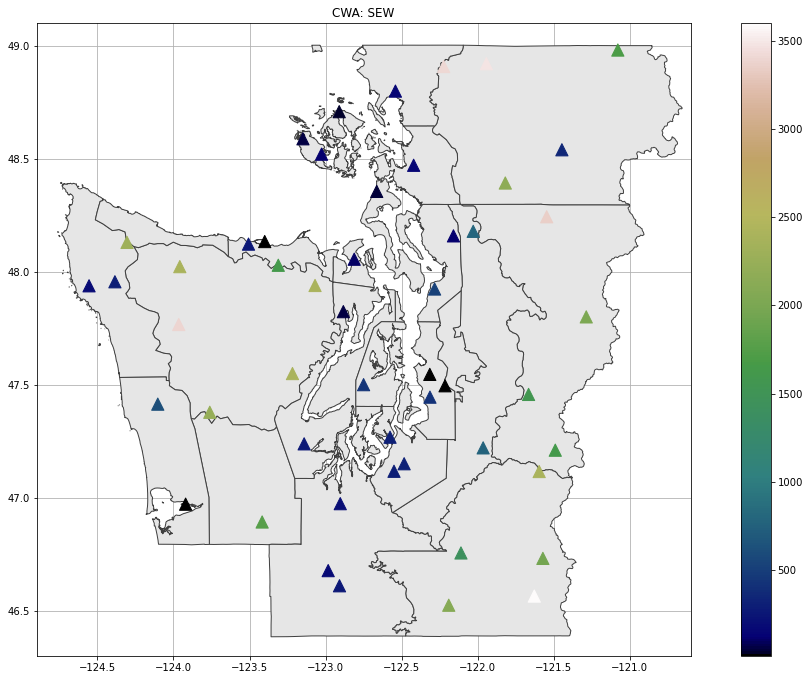

In [260]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w')
ax.set_title('CWA: %s'%cwa)

zones.plot(column='NAME', color='0.9', edgecolor='0.25', ax=ax, zorder=10)

cbd = ax.scatter(meta['LONGITUDE'], meta['LATITUDE'], c=meta['ELEVATION'], cmap='gist_earth', s=150, marker='^', zorder=20,)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5)
plt.colorbar(cbd, cax=cax)
ax.grid(True, zorder=-10)

ax.set_ylim(bottom=46.30, top=49.10)
ax.set_xlim(left=-124.9, right=-120.6)

fig.show()

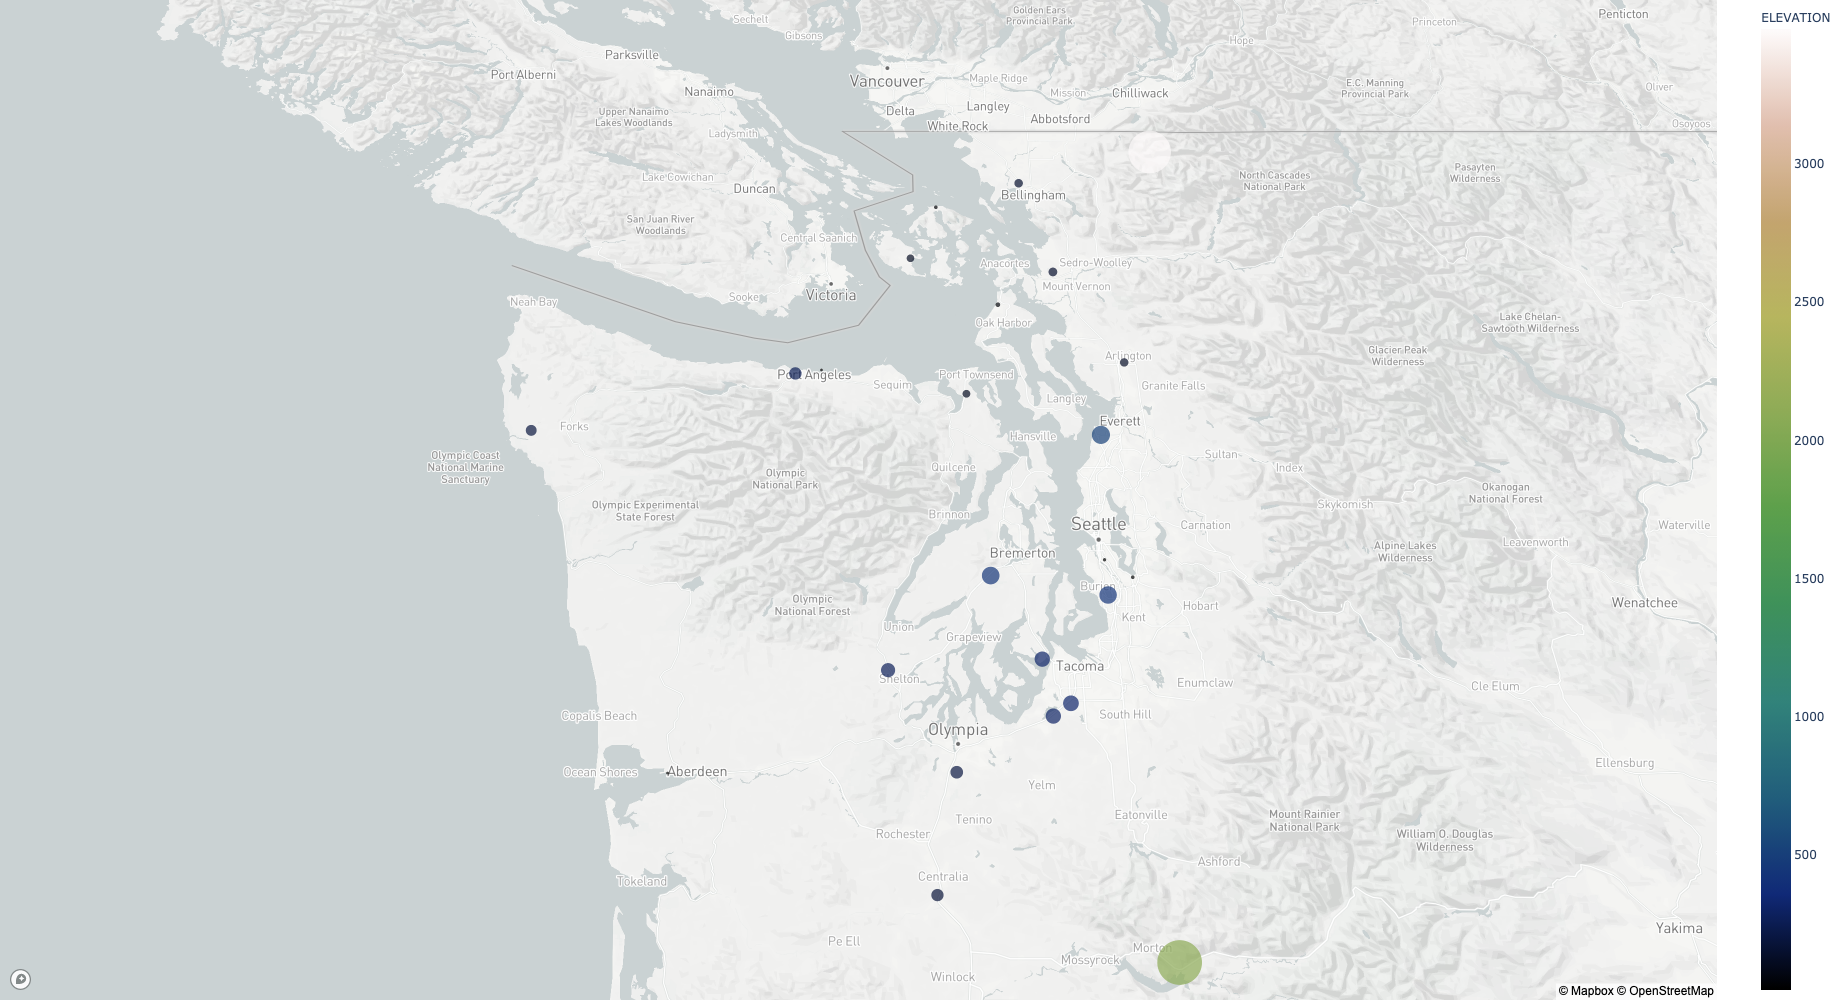

In [154]:
import plotly.express as px
from matplotlib import cm

def mpl_to_plotly(cmap, pl_entries=11, rdigits=2):
    # cmap - colormap 
    # pl_entries - int = number of Plotly colorscale entries
    # rdigits - int -=number of digits for rounding scale values
    scale = np.linspace(0, 1, pl_entries)
    colors = (cmap(scale)[:, :3]*255).astype(np.uint8)
    pl_colorscale = [[round(s, rdigits), f'rgb{tuple(color)}'] for s, color in zip(scale, colors)]
    return pl_colorscale

px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(meta,
        lat="LATITUDE", lon="LONGITUDE",
        color="ELEVATION", size="ELEVATION",
        color_continuous_scale=mpl_to_plotly(cm.get_cmap('gist_earth')), 
        size_max=35, 
        zoom=1)

fig.update_layout(
    autosize=False,
    width=1000, height=1000,
    margin=dict(l=0, r=0, t=0, b=0, pad=0),
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        style='light',
        bearing=0,
        center=dict(
            lat=(max(meta['LATITUDE']) + min(meta['LATITUDE']))/2,
            lon=(max(meta['LONGITUDE']) + min(meta['LONGITUDE']))/2,
        ),
        pitch=30,
        zoom=7.5
    ),
)

fig.show()

<hr><hr>

In [150]:
with mp.get_context('fork').Pool(mp.cpu_count()*2) as p:
    ob_files = p.map(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
    p.close()
    p.join()

obs = []
for file in ob_files:
    site = file.split('/')[-1].split('_')[0]
    iobs = pd.read_pickle(file)
    iobs['Site'] = np.full(iobs.index.size, fill_value=site, dtype='U10')
    iobs = iobs.reset_index().set_index(['ValidTime', 'Site'])
    obs.append(iobs)
    
obs = pd.concat(obs).sort_index()

mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual data
obs = obs.dropna(how='all')

sites = np.unique(obs.index.get_level_values(1))
print(sites)

print(obs.shape)
obs.head(10)

['K0S9' 'KAWO' 'KBFI' 'KBLI' 'KBVS' 'KCFW1' 'KCLM' 'KCLS' 'KFHR' 'KGRF'
 'KHQM' 'KNOW' 'KNUW' 'KOLM' 'KORS' 'KOSW1' 'KPAE' 'KPWT' 'KRNT' 'KSEA'
 'KSHN' 'KTCM' 'KTIW' 'KUIL']
(16842, 3)


6h_precip_in  12h_precip_in  24h_precip_in
ValidTime  Site                                             
2020-03-02 K0S9           0.00           0.00           0.00
           KAWO           0.01           0.01           0.01
           KBFI           0.00           0.00           0.09
           KBLI           0.00           0.00           0.00
           KBVS           0.01           0.02           0.02
           KCFW1          0.06           0.06           0.13
           KCLM           0.00           0.00           0.00
           KCLS           0.00           0.00           0.00
           KFHR           0.00           0.00           0.00
           KGRF           0.00           0.00           0.00

In [ ]:
obs.describe().T

***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [ ]:
with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
    nbm_files = p.map_async(nbm_funcs.get_nbm_1d_mp, meta.index, chunksize=1)
    nbm_files.wait()
    
nbm_files = [f for f in nbm_files.get() if f is not None]

nbm = []
for file in nbm_files:
    site = file.split('/')[-1].split('_')[0]
    inbm = pd.read_pickle(file)
    inbm['Site'] = np.full(inbm.index.size, fill_value=site, dtype='U10')
    inbm = inbm.reset_index().set_index(['InitTime', 'ValidTime', 'Site'])
    nbm.append(inbm)
    
nbm = pd.concat(nbm).sort_index()
nbm

# Convert mm to in
nbm *= mm_in

lead = [row[1]-row[0] for row in nbm.index]
lead = np.array([1 + row.days*24 + (row.seconds/3600) for row in lead], dtype=int)
nbm.insert(0, 'LeadTime', lead)

# Nix values where lead time shorter than acc interval
for k in [k for k in nbm.keys() if k != 'LeadTime']:
    if 'APCP24hr' in k:
        nbm[k][nbm['LeadTime'] < 24] = np.nan
    elif 'APCP12hr' in k:
        nbm[k][nbm['LeadTime'] < 12] = np.nan
    elif 'APCP6r' in k:
        nbm[k][nbm['LeadTime'] < 6] = np.nan
    else:
        pass
    
nbm = nbm.dropna(subset=[k for k in nbm.keys() if k != 'LeadTime'], how='all')
nbm.tail(25)

In [ ]:
# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level'
            ]].describe().T

#### Plot the distribution of precipitation observations vs forecasts for assessment of representativeness

In [ ]:
# Label fix:
site = nbm_funcs._site = zone_query.replace('&', '').replace('=', '_').upper()

figdir = nbm_funcs._figdir = '../archive//%s/figures/'%site
os.makedirs(figdir, exist_ok=True)

In [ ]:
thresh_id = nbm_funcs._thresh_id = {'Small':[0, 1], 'Medium':[1, 2], 'Large':[2, 3], 'All':[0, 3]}

# 33rd, 67th percentile determined above
thresholds = nbm_funcs._thresholds = {interval:nbm_funcs.apcp_dist_plot(obs, nbm, interval, show=True) 
              for interval in [6, 12, 24]}

thresholds

***
***
# Reorganize the data for analysis:
#### Isolate the forecasts by accumulation interval and lead time

In [ ]:
plist = np.arange(1, 100)

data = []
for interval in [6, 12, 24]:
    
    pkeys = np.array([k for k in nbm.keys() if '%dhr_'%interval in k])
    pkeys = np.array([k for k in pkeys if '%' in k])
    pkeys = pkeys[np.argsort([int(k.split('_')[-1].split('%')[0]) for k in pkeys])]
    
    for lead_time in np.arange(interval, lead_time_end, 6):
        
        for esize in ['Small', 'Medium', 'Large']:
            
            thresh = [thresholds[interval][thresh_id[esize][0]], 
                      thresholds[interval][thresh_id[esize][1]]]
        
            print('\rProcessing interval %d lead %dh'%(interval, lead_time), end='')

            # We need to break out the verification to each lead time,
            # but within each lead time we have a number of valid times.
            # At each lead time, valid time, isolate the forecast verification

            # Combine the datasets to make it easier to work with
            idata = nbm[nbm['LeadTime'] == lead_time].merge(obs, on=['ValidTime', 'Site']).drop(columns='LeadTime')

            # Subset for event size using the observed precip
            iobs = idata['%dh_precip_in'%interval]
            # Do the trimming of the selected dataset
            idata = idata[((iobs >= thresh[0]) & (iobs < thresh[1]))]
            del iobs
            
            for itime in idata.index:

                try:
                    prob_fx = idata.loc[itime, pkeys]
                    mean_fx = np.nanmean(prob_fx)
                    std_fx = np.nanstd(prob_fx)
                    med_fx = idata.loc[itime, 'APCP%dhr_surface_50%% level'%interval]
                    det_fx = idata.loc[itime, 'APCP%dhr_surface'%interval]

                    # Optional - leave as nan?
                    det_fx = det_fx if ~np.isnan(det_fx) else 0.

                    verif_ob = idata.loc[itime, '%dh_precip_in'%interval]
                    
                    verif_rank = np.searchsorted(prob_fx, verif_ob, 'right')                    
                    verif_rank_val = prob_fx[verif_rank-1]
                    verif_rank_error = verif_rank_val - verif_ob
                    
                    verif_rank = 101 if ((verif_rank >= 99) & (verif_ob > verif_rank_val)) else verif_rank
                    verif_rank = -1 if ((verif_rank <= 1) & (verif_ob < verif_rank_val)) else verif_rank
                    
                    det_rank = np.searchsorted(prob_fx, det_fx, 'right')
                    det_error = det_fx - verif_ob

                except:
                    pass
                    # print('failed', itime)

                else:
                    if ((verif_ob > 0.) & ~np.isnan(verif_rank_val)):

                        data.append([
                            # Indexers
                            interval, lead_time, itime[0], itime[1], esize,

                            # Verification and deterministic
                            verif_ob, det_fx, det_rank, det_error,

                            # Probabilistic
                            verif_rank, verif_rank_val, verif_rank_error, 
                            med_fx, mean_fx, std_fx])

data = pd.DataFrame(data, columns=['Interval', 'LeadTime', 'ValidTime', 'Site', 'EventSize',
                'verif_ob', 'det_fx', 'det_rank', 'det_error',
                'verif_rank', 'verif_rank_val', 'verif_rank_error', 
                'med_fx', 'mean_fx', 'std_fx'])

print('\n\nAvailable keys:\n\t\t{}\nn rows: {}'.format('\n\t\t'.join(data.keys()), len(data)))

***
***
# Create Bulk Temporal Stats Plots
#### Reliability diagrams, bias over time, rank over time, etc.

In [ ]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long,
             '_plot_type':plot_type, '_plot_var':plot_var}
    
    nbm_funcs.histograms_verif_rank(data, **kwargs, show=False)

#### Plot a reliability diagram style CDF to evaluate percentile rankings

In [ ]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long,
             '_plot_type':plot_type, '_plot_var':plot_var}

    nbm_funcs.reliability_verif_cdf_multistation(data, **kwargs, show=False)

#### Produce bias, ME, MAE, and percentile rank plots as they evolve over time
This helps illustrate at what leads a dry/wet bias may exist and how severe it may be<br>
Adds value in interpreting the CDF reliability diagrams

In [ ]:
short, long = 0, 120
esize = 'All'

for interval in [6, 12, 24]:

    kwargs = {'_interval':interval, '_esize':esize,
             '_short':short, '_long':long}

    nbm_funcs.rank_over_leadtime(data, **kwargs, show=False)

In [ ]:
# Create maps of rank at each station over the CWA with mean verif and mean det